In [1]:
import os
import io
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torchvision
import pandas as pd
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
label_mappings = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}


class GuitarDataset(Dataset):
    """Guitar Dataset"""

    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if train:
          self.root_dir = os.path.join(root_dir, 'train')
        else:
          self.root_dir = os.path.join(root_dir, 'test')
        self.transform = transform
        self.image_names = [name for name in os.listdir(self.root_dir) if name.endswith('.jpg') or name.endswith('.jpeg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        """
        Funzione per ottenere un elemento del dataset

        :param idx: Indice dell'elemento
        :return: Una tupla (immagine, label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        image = cv.imread(img_name)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = np.moveaxis(image, 2, 0)
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image)

        img_base_name = os.path.basename(img_name)
        label = label_mappings.get(img_base_name.split(' ')[0])

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [4]:
# montare Google Drive. Si può fare dall'interfaccia grafica del sito

In [5]:
num_classes = 7

In [6]:
pretrained = True
model = torchvision.models.mobilenet_v2(pretrained=pretrained)
if pretrained:
  pretrained_str = '_pretrained'
else:
  pretrained_str = ''
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Uncomment the following line to train only the last layers
#set_parameter_requires_grad(model, feature_extract)

In [9]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [10]:
test_classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.2, inplace=False),
    torch.nn.Linear(in_features=1280, out_features=1280),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=1280, out_features=num_classes),
)

In [11]:
model.classifier = test_classifier
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1280, bias=True)
  (2): ReLU()
  (3): Linear(in_features=1280, out_features=7, bias=True)
)

In [12]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.Resize((280, 218))
])

dataset_str = 'cropped_images'
#dataset_str = 'cropped_rotated_images'
#dataset_str = 'cropped_processed_rotated_images'
#dataset_str = 'cropped_rotated_processed_images_1'
#dataset_str = 'cropped_rotated_processed_images_2'

training_dataset = GuitarDataset('drive/MyDrive/chords_data/' + dataset_str, transform=transform, train=True)

train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=8)

testing_dataset = GuitarDataset('drive/MyDrive/chords_data/' + dataset_str, transform=transform, train=False)

validation_loader = DataLoader(testing_dataset, batch_size=32, shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"GPU found! Using {device}...")

num_epochs = 20
learning_rate = 0.001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

GPU found! Using cuda:0...


In [14]:
model = model.to(device)

In [15]:
import csv
csv_header = ['Classification loss']

csvfile = open(dataset_str + pretrained_str + '_mobilenetv2_loss.csv', 'w', newline='')
writer = csv.writer(csvfile)
writer.writerow(csv_header)

21

In [16]:
best_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            for i, (imgs, labels) in enumerate(tqdm(train_loader)):
              labels = torch.nn.functional.one_hot(labels, num_classes=7).float()
              imgs = imgs.to(device)
              labels = labels.to(device)
              outputs = model(imgs)
              outputs = torch.nn.functional.softmax(outputs, dim=1)
              loss = criterion(outputs, labels)
              # writing loss in csv file
              row = [loss.item()]
              writer.writerow(row)

              #import pdb; pdb.set_trace()
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

        else:
            model.eval()   # Set model to evaluate mode
            num_correct = 0
            num_samples = 0

            with torch.no_grad():
                for x, y in validation_loader:
                    x = x.to(device=device)
                    y = y.to(device=device)

                    scores = model(x)
                    #import pdb; pdb.set_trace()
                    # predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
                    predictions = scores.argmax(1)
                    num_correct += (predictions == y).sum()
                    num_samples += predictions.size(0)
                    acc = float(num_correct) / float(num_samples) * 100
                    print(
                        f"Got {num_correct} / {num_samples} with accuracy {acc:.2f}"
                    )
                if acc > best_acc:
                  best_acc = acc
                  best_model_wts = copy.deepcopy(model.state_dict())

----------
Epoch 0/19


  0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Got 13 / 32 with accuracy 40.62
Got 31 / 64 with accuracy 48.44
Got 51 / 96 with accuracy 53.12
Got 72 / 128 with accuracy 56.25
Got 72 / 130 with accuracy 55.38
----------
Epoch 1/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 24 / 32 with accuracy 75.00
Got 42 / 64 with accuracy 65.62
Got 56 / 96 with accuracy 58.33
Got 76 / 128 with accuracy 59.38
Got 77 / 130 with accuracy 59.23
----------
Epoch 2/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 30 / 32 with accuracy 93.75
Got 54 / 64 with accuracy 84.38
Got 78 / 96 with accuracy 81.25
Got 106 / 128 with accuracy 82.81
Got 108 / 130 with accuracy 83.08
----------
Epoch 3/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 23 / 32 with accuracy 71.88
Got 50 / 64 with accuracy 78.12
Got 75 / 96 with accuracy 78.12
Got 104 / 128 with accuracy 81.25
Got 105 / 130 with accuracy 80.77
----------
Epoch 4/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 28 / 32 with accuracy 87.50
Got 56 / 64 with accuracy 87.50
Got 82 / 96 with accuracy 85.42
Got 109 / 128 with accuracy 85.16
Got 111 / 130 with accuracy 85.38
----------
Epoch 5/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 26 / 32 with accuracy 81.25
Got 53 / 64 with accuracy 82.81
Got 80 / 96 with accuracy 83.33
Got 103 / 128 with accuracy 80.47
Got 105 / 130 with accuracy 80.77
----------
Epoch 6/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 28 / 32 with accuracy 87.50
Got 56 / 64 with accuracy 87.50
Got 84 / 96 with accuracy 87.50
Got 115 / 128 with accuracy 89.84
Got 117 / 130 with accuracy 90.00
----------
Epoch 7/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 27 / 32 with accuracy 84.38
Got 53 / 64 with accuracy 82.81
Got 75 / 96 with accuracy 78.12
Got 103 / 128 with accuracy 80.47
Got 105 / 130 with accuracy 80.77
----------
Epoch 8/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 30 / 32 with accuracy 93.75
Got 60 / 64 with accuracy 93.75
Got 88 / 96 with accuracy 91.67
Got 119 / 128 with accuracy 92.97
Got 121 / 130 with accuracy 93.08
----------
Epoch 9/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 26 / 32 with accuracy 81.25
Got 53 / 64 with accuracy 82.81
Got 82 / 96 with accuracy 85.42
Got 107 / 128 with accuracy 83.59
Got 107 / 130 with accuracy 82.31
----------
Epoch 10/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 29 / 32 with accuracy 90.62
Got 56 / 64 with accuracy 87.50
Got 83 / 96 with accuracy 86.46
Got 110 / 128 with accuracy 85.94
Got 112 / 130 with accuracy 86.15
----------
Epoch 11/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 29 / 32 with accuracy 90.62
Got 58 / 64 with accuracy 90.62
Got 87 / 96 with accuracy 90.62
Got 119 / 128 with accuracy 92.97
Got 121 / 130 with accuracy 93.08
----------
Epoch 12/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 27 / 32 with accuracy 84.38
Got 55 / 64 with accuracy 85.94
Got 84 / 96 with accuracy 87.50
Got 108 / 128 with accuracy 84.38
Got 110 / 130 with accuracy 84.62
----------
Epoch 13/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 21 / 32 with accuracy 65.62
Got 42 / 64 with accuracy 65.62
Got 64 / 96 with accuracy 66.67
Got 82 / 128 with accuracy 64.06
Got 83 / 130 with accuracy 63.85
----------
Epoch 14/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 28 / 32 with accuracy 87.50
Got 56 / 64 with accuracy 87.50
Got 84 / 96 with accuracy 87.50
Got 112 / 128 with accuracy 87.50
Got 114 / 130 with accuracy 87.69
----------
Epoch 15/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 32 / 32 with accuracy 100.00
Got 60 / 64 with accuracy 93.75
Got 88 / 96 with accuracy 91.67
Got 120 / 128 with accuracy 93.75
Got 121 / 130 with accuracy 93.08
----------
Epoch 16/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 24 / 32 with accuracy 75.00
Got 46 / 64 with accuracy 71.88
Got 68 / 96 with accuracy 70.83
Got 95 / 128 with accuracy 74.22
Got 96 / 130 with accuracy 73.85
----------
Epoch 17/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 30 / 32 with accuracy 93.75
Got 55 / 64 with accuracy 85.94
Got 85 / 96 with accuracy 88.54
Got 115 / 128 with accuracy 89.84
Got 116 / 130 with accuracy 89.23
----------
Epoch 18/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 25 / 32 with accuracy 78.12
Got 48 / 64 with accuracy 75.00
Got 74 / 96 with accuracy 77.08
Got 100 / 128 with accuracy 78.12
Got 102 / 130 with accuracy 78.46
----------
Epoch 19/19


  0%|          | 0/17 [00:00<?, ?it/s]

Got 30 / 32 with accuracy 93.75
Got 59 / 64 with accuracy 92.19
Got 88 / 96 with accuracy 91.67
Got 117 / 128 with accuracy 91.41
Got 119 / 130 with accuracy 91.54


In [17]:
csvfile.close()

In [18]:
best_acc

93.07692307692308

In [19]:
torch.save(best_model_wts, 'drive/MyDrive/salvataggi_pytorch/classification_network/' + dataset_str + '_model_state_dict')

In [20]:
model.load_state_dict(torch.load('drive/MyDrive/salvataggi_pytorch/classification_network/' + dataset_str + '_model_state_dict'))
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [21]:
testloader = DataLoader(testing_dataset, batch_size=len(testing_dataset), shuffle=True, num_workers=8)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
dataiter = iter(testloader)
x, y = next(dataiter)
x = x.to(device)
y = y.to(device)
scores = model(x)
predictions = scores.argmax(1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [23]:
predictions

tensor([0, 3, 1, 6, 6, 5, 1, 6, 2, 2, 6, 3, 4, 1, 3, 4, 3, 1, 4, 5, 5, 6, 2, 5,
        5, 0, 3, 5, 5, 4, 3, 1, 4, 3, 3, 6, 3, 0, 5, 2, 1, 6, 2, 2, 5, 3, 5, 0,
        3, 6, 6, 1, 2, 3, 3, 0, 4, 2, 0, 4, 0, 2, 5, 1, 5, 5, 2, 5, 5, 1, 2, 0,
        2, 0, 4, 1, 2, 5, 3, 1, 2, 3, 1, 0, 0, 2, 3, 0, 5, 2, 2, 0, 3, 2, 2, 6,
        2, 0, 6, 0, 2, 1, 5, 2, 1, 2, 1, 3, 0, 6, 4, 5, 1, 2, 6, 5, 3, 3, 3, 4,
        2, 5, 2, 0, 5, 1, 3, 6, 6, 2], device='cuda:0')

In [24]:
y

tensor([4, 3, 1, 6, 6, 5, 1, 6, 1, 2, 6, 3, 4, 1, 3, 4, 3, 1, 4, 5, 5, 6, 2, 5,
        5, 0, 3, 5, 4, 4, 3, 1, 4, 3, 3, 6, 3, 0, 5, 2, 1, 6, 2, 2, 5, 3, 5, 3,
        3, 6, 6, 1, 2, 3, 3, 0, 4, 2, 0, 0, 4, 2, 5, 1, 5, 5, 2, 5, 5, 1, 2, 0,
        2, 0, 4, 1, 2, 5, 3, 1, 2, 3, 1, 0, 0, 2, 3, 0, 5, 2, 2, 0, 3, 2, 2, 6,
        2, 0, 6, 0, 2, 1, 5, 2, 1, 2, 1, 3, 0, 6, 4, 5, 1, 2, 6, 5, 4, 0, 3, 4,
        2, 4, 2, 0, 5, 1, 3, 6, 6, 2], device='cuda:0')

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame({'predictions': predictions.cpu().numpy(), 'y_true': y.cpu().numpy()})
df.to_csv(dataset_str + pretrained_str + '_mobilenetv2_predictions__ytrue.csv', index=False)
df

,predictions,y_true
0,0,4
1,3,3
2,1,1
3,6,6
4,6,6
...,...,...
125,1,1
126,3,3
127,6,6
128,6,6


In [27]:
preds = df['predictions'].values
preds

array([0, 3, 1, 6, 6, 5, 1, 6, 2, 2, 6, 3, 4, 1, 3, 4, 3, 1, 4, 5, 5, 6,
       2, 5, 5, 0, 3, 5, 5, 4, 3, 1, 4, 3, 3, 6, 3, 0, 5, 2, 1, 6, 2, 2,
       5, 3, 5, 0, 3, 6, 6, 1, 2, 3, 3, 0, 4, 2, 0, 4, 0, 2, 5, 1, 5, 5,
       2, 5, 5, 1, 2, 0, 2, 0, 4, 1, 2, 5, 3, 1, 2, 3, 1, 0, 0, 2, 3, 0,
       5, 2, 2, 0, 3, 2, 2, 6, 2, 0, 6, 0, 2, 1, 5, 2, 1, 2, 1, 3, 0, 6,
       4, 5, 1, 2, 6, 5, 3, 3, 3, 4, 2, 5, 2, 0, 5, 1, 3, 6, 6, 2])

In [28]:
y_true = df['y_true'].values
y_true

array([4, 3, 1, 6, 6, 5, 1, 6, 1, 2, 6, 3, 4, 1, 3, 4, 3, 1, 4, 5, 5, 6,
       2, 5, 5, 0, 3, 5, 4, 4, 3, 1, 4, 3, 3, 6, 3, 0, 5, 2, 1, 6, 2, 2,
       5, 3, 5, 3, 3, 6, 6, 1, 2, 3, 3, 0, 4, 2, 0, 0, 4, 2, 5, 1, 5, 5,
       2, 5, 5, 1, 2, 0, 2, 0, 4, 1, 2, 5, 3, 1, 2, 3, 1, 0, 0, 2, 3, 0,
       5, 2, 2, 0, 3, 2, 2, 6, 2, 0, 6, 0, 2, 1, 5, 2, 1, 2, 1, 3, 0, 6,
       4, 5, 1, 2, 6, 5, 4, 0, 3, 4, 2, 4, 2, 0, 5, 1, 3, 6, 6, 2])

In [29]:
reverse_label_mappings = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G'
}

In [30]:
results_dict = {}
for i in range(7):
  results_dict[reverse_label_mappings[i]] = []
  results_dict[reverse_label_mappings[i]].append(((preds == y_true) & (y_true == i)).sum())
  results_dict[reverse_label_mappings[i]].append((y_true == i).sum())

In [31]:
results_dict

{'A': [14, 16],
 'B': [17, 18],
 'C': [26, 26],
 'D': [20, 21],
 'E': [9, 14],
 'F': [20, 20],
 'G': [15, 15]}

In [32]:
df = pd.DataFrame(results_dict, index=['num_correct', 'num_samples'])
df = df.T
df.to_csv(dataset_str + pretrained_str + '_mobilenetv2_performances.csv')
df

,num_correct,num_samples
A,14,16
B,17,18
C,26,26
D,20,21
E,9,14
F,20,20
G,15,15


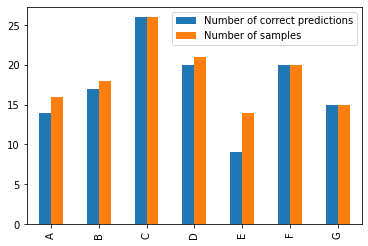

In [33]:
ax = df.plot.bar()
ax.legend(labels=['Number of correct predictions', 'Number of samples'])
plt.savefig(dataset_str + pretrained_str + '_mobilenetv2_predictions.png', bbox_inches='tight')
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [35]:
print(confusion_matrix(y_true, preds))

[[14  0  0  1  1  0  0]
 [ 0 17  1  0  0  0  0]
 [ 0  0 26  0  0  0  0]
 [ 1  0  0 20  0  0  0]
 [ 2  0  0  1  9  2  0]
 [ 0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0 15]]


In [36]:
accuracy = accuracy_score(y_true, preds)
accuracy

0.9307692307692308

In [37]:
with open(dataset_str + pretrained_str + '_mobilenet_v2_accuracy.txt', 'wt') as f:
  f.write(str(accuracy))

In [38]:
precision = precision_score(y_true, preds, average=None)
precision

array([0.82352941, 1.        , 0.96296296, 0.90909091, 0.9       ,
       0.90909091, 1.        ])

In [39]:
recall = recall_score(y_true, preds, average=None)
recall

array([0.875     , 0.94444444, 1.        , 0.95238095, 0.64285714,
       1.        , 1.        ])

In [40]:
f1_score = f1_score(y_true, preds, average=None)
f1_score

array([0.84848485, 0.97142857, 0.98113208, 0.93023256, 0.75      ,
       0.95238095, 1.        ])

In [41]:
df = pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score
}, index=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
df.to_csv(dataset_str + pretrained_str + '_mobilenetv2_precision_recall_f1_score.csv')
df

,precision,recall,f1_score
A,0.823529,0.875000,0.848485
B,1.000000,0.944444,0.971429
C,0.962963,1.000000,0.981132
D,0.909091,0.952381,0.930233
E,0.900000,0.642857,0.750000
F,0.909091,1.000000,0.952381
G,1.000000,1.000000,1.000000


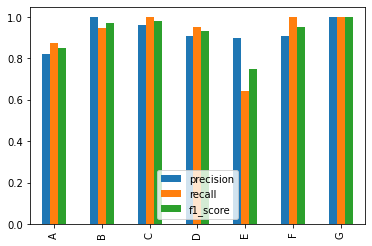

In [42]:
df.plot.bar()